In [19]:
!pip install -q kaggle


In [20]:
! mkdir -p ~/.kaggle
! cp ~/kaggle.json ~/.kaggle/   # adjust path if needed
! chmod 600 ~/.kaggle/kaggle.json

In [21]:
# Where is HOME for this kernel?
!echo $HOME

# Does the file exist and have 600 perms?
!ls -l ~/.kaggle
!ls -l ~/.kaggle/kaggle.json

# Peek at the *shape* (confirm keys exist). DO NOT share output publicly.
!cat ~/.kaggle/kaggle.json

/Users/alex
total 8
-rw-------@ 1 alex  staff  73 Aug 25 15:46 kaggle.json
-rw-------@ 1 alex  staff  73 Aug 25 15:46 /Users/alex/.kaggle/kaggle.json
{"username":"alextheambitious","key":"cbe0ae38313eef2ff35a847ae89ec723"}


In [23]:
!kaggle competitions download -c mercari-price-suggestion-challenge -p data/raw --force

 99%|███████████████████████████████████████▌| 399M/403M [00:08<00:00, 52.9MB/s]
100%|████████████████████████████████████████| 403M/403M [00:08<00:00, 51.9MB/s]


In [30]:
!unzip "data/raw/mercari-price-suggestion-challenge.zip" -d "data/raw"

Archive:  data/raw/mercari-price-suggestion-challenge.zip
  inflating: data/raw/sample_submission.csv.7z  
  inflating: data/raw/sample_submission_stg2.csv.zip  
  inflating: data/raw/test.tsv.7z    
  inflating: data/raw/test_stg2.tsv.zip  
  inflating: data/raw/train.tsv.7z   


Running `brew update --auto-update`...
==> Downloading https://ghcr.io/v2/homebrew/portable-ruby/portable-ruby/blobs/sha256:20fa657858e44a4b39171d6e4111f8a9716eb62a78ebbd1491d94f90bb7b830a
######################################################################### 100.0%
==> Pouring portable-ruby-3.4.5.arm64_big_sur.bottle.tar.gz
==> Homebrew collects anonymous analytics.
Read the analytics documentation (and how to opt-out) here:
  https://docs.brew.sh/Analytics
No analytics have been recorded yet (nor will be during this `brew` run).

==> Homebrew is run entirely by unpaid volunteers. Please consider donating:
  https://github.com/Homebrew/brew#donations

==> homebrew/cask is old and unneeded, untapping to save space...
Untapping homebrew/cask...
Untapped 7579 casks (4,321 files, 365.5MB).
==> Auto-updated Homebrew!
Updated 2 taps (homebrew/core and homebrew/cask).
==> New Formulae
ab-av1: AV1 re-encoding using ffmpeg, svt-av1 & vmaf
abpoa: SIMD-based C library for fast partial order 

In [37]:
!7z x data/raw/train.tsv.7z -o./data/raw/dataset
!7z x data/raw/test.tsv.7z -o./data/raw/dataset


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,10 CPUs LE)

Scanning the drive for archives:
1 file, 77912192 bytes (75 MiB)

Extracting archive: data/raw/train.tsv.7z
--
Path = data/raw/train.tsv.7z
Type = 7z
Physical Size = 77912192
Headers Size = 122
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       337809843
Compressed: 77912192

7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,10 CPUs LE)

Scanning the drive for archives:
1 file, 35617013 bytes (34 MiB)

Extracting archive: data/raw/test.tsv.7z
--
Path = data/raw/test.tsv.7z
Type = 7z
Physical Size = 35617013
Headers Size = 122
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       154222160
Compressed: 35617013


In [120]:
import pandas as pd
df = pd.read_csv('data/raw/dataset/train.tsv', sep='\t')
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [153]:
test = pd.read_csv('data/raw/dataset/test.tsv', sep='\t')
test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


In [156]:
# test.drop(columns = ["train_id", "shipping"])
test.brand_name= test.brand_name.fillna('unknown')
test.category_name = test.category_name.fillna('unknown')
# df[['cat1', 'cat2', 'cat3']] = df['category_name'].str.split('/', expand=True, n=2)
# df.drop(columns=['train_id', 'shipping'], inplace=True)
for col in test.columns:
    if test[col].dtype == "object":  # only apply to text columns
        test[col] = test[col].str.lower()
test.item_description.replace('no description yet', 'unknown', inplace=True)
test.head()

/var/folders/g5/vc01zl257wv_wr6234qdn03r0000gn/T/ipykernel_3132/1468489178.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test.item_description.replace('no description yet', 'unknown', inplace=True)


,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"breast cancer ""i fight like a girl"" ring",1,women/jewelry/rings,unknown,1,size 7
1,1,"25 pcs new 7.5""x12"" kraft bubble mailers",1,other/office supplies/shipping supplies,unknown,1,"25 pcs new 7.5""x12"" kraft bubble mailers lined..."
2,2,coach bag,1,vintage & collectibles/bags and purses/handbag,coach,1,brand new coach bag. bought for [rm] at a coac...
3,3,floral kimono,2,women/sweaters/cardigan,unknown,0,-floral kimono -never worn -lightweight and pe...
4,4,life after death,3,other/books/religion & spirituality,unknown,1,rediscovering life after the loss of a loved o...


In [121]:
df.drop(columns=['train_id', 'shipping'], inplace=True)
df.head()

,name,item_condition_id,category_name,brand_name,price,item_description
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,Complete with certificate of authenticity


In [123]:
df.brand_name= df.brand_name.fillna('unknown')
df.category_name = df.category_name.fillna('unknown')
# df[['cat1', 'cat2', 'cat3']] = df['category_name'].str.split('/', expand=True, n=2)
# df.drop(columns=['train_id', 'shipping'], inplace=True)
for col in df.columns:
    if df[col].dtype == "object":  # only apply to text columns
        df[col] = df[col].str.lower()
df.item_description.replace('no description yet', 'unknown', inplace=True)
df.head

/var/folders/g5/vc01zl257wv_wr6234qdn03r0000gn/T/ipykernel_3132/1065228977.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.item_description.replace('no description yet', 'unknown', inplace=True)


<bound method NDFrame.head of                                           name  item_condition_id  \
0          mlb cincinnati reds t shirt size xl                  3   
1             razer blackwidow chroma keyboard                  3   
2                               ava-viv blouse                  1   
3                        leather horse statues                  1   
4                         24k gold plated rose                  1   
...                                        ...                ...   
1482530             free people inspired dress                  2   
1482531          little mermaid handmade dress                  2   
1482532  21 day fix containers and eating plan                  2   
1482533                 world markets lanterns                  3   
1482534          brand new lux de ville wallet                  1   

                                             category_name   brand_name  \
0                                        men/tops/t-shirts      un

In [64]:
df.drop(['category_name'], axis=1, inplace=True)
# df.str.lower()
df.head()


,name,item_condition_id,brand_name,price,item_description,cat1,cat2,cat3
0,MLB Cincinnati Reds T Shirt Size XL,3,unknown,10.0,No description yet,Men,Tops,T-shirts
1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,AVA-VIV Blouse,1,Target,10.0,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,Leather Horse Statues,1,unknown,35.0,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,24K GOLD plated rose,1,unknown,44.0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [87]:
# print(type(df.loc[1, :]))
# print(type(df.iloc[:, 0]))
for col in df.columns:
    if df[col].dtype == "object":  # only apply to text columns
        df[col] = df[col].str.lower()
df.item_description.replace('no description yet', 'unknown', inplace=True)
df.head()
# for :
#     print(type(column))

/var/folders/g5/vc01zl257wv_wr6234qdn03r0000gn/T/ipykernel_3132/3932397014.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.item_description.replace('no description yet', 'unknown', inplace=True)


,name,item_condition_id,brand_name,price,item_description,cat1,cat2,cat3
0,mlb cincinnati reds t shirt size xl,3,unknown,10.0,unknown,men,tops,t-shirts
1,razer blackwidow chroma keyboard,3,razer,52.0,this keyboard is in great condition and works ...,electronics,computers & tablets,components & parts
2,ava-viv blouse,1,target,10.0,adorable top with a hint of lace and a key hol...,women,tops & blouses,blouse
3,leather horse statues,1,unknown,35.0,new with tags. leather horses. retail for [rm]...,home,home décor,home décor accents
4,24k gold plated rose,1,unknown,44.0,complete with certificate of authenticity,women,jewelry,necklaces


In [89]:
# Combine categories into one string
df["category"] = df[["cat1", "cat2", "cat3"]].fillna("").agg(" / ".join, axis=1)

# Strip trailing slashes/spaces if some categories were empty
df["category"] = df["category"].str.strip("/")

# Optional: drop the old columns to keep things tidy
df.drop(["cat1", "cat2", "cat3"], axis=1, inplace=True)

# Preview
df[["category", "price", "item_description"]].head(10)

KeyError: "None of [Index(['cat1', 'cat2', 'cat3'], dtype='object')] are in the [columns]"

In [124]:
# Drop rows where description is "unknown"
df = df[df['item_description'] != "unknown"].copy()
df = df.drop_duplicates(subset=["name", "item_description", "brand_name"])
df = df[df["price"] > 0]
df = df[df["price"] < 10000]
print("Remaining rows:", df.shape[0])

Remaining rows: 1394534


In [157]:
# Drop rows where description is "unknown"
test = test[test['item_description'] != "unknown"].copy()
test = test.drop_duplicates(subset=["name", "item_description", "brand_name"])
test = test[test["price"] > 0]
test = test[test["price"] < 10000]
print("Remaining rows:", test.shape[0])

KeyError: 'price'

In [126]:
print((df["brand_name"] == "unknown").sum())
print((df["category_name"] == "unknown").sum())
print((df["item_description"] == "unknown").sum())


591555
5683
0


count    1.394534e+06
mean     2.706849e+01
std      3.909978e+01
min      3.000000e+00
25%      1.100000e+01
50%      1.700000e+01
75%      3.000000e+01
max      2.009000e+03
Name: price, dtype: float64


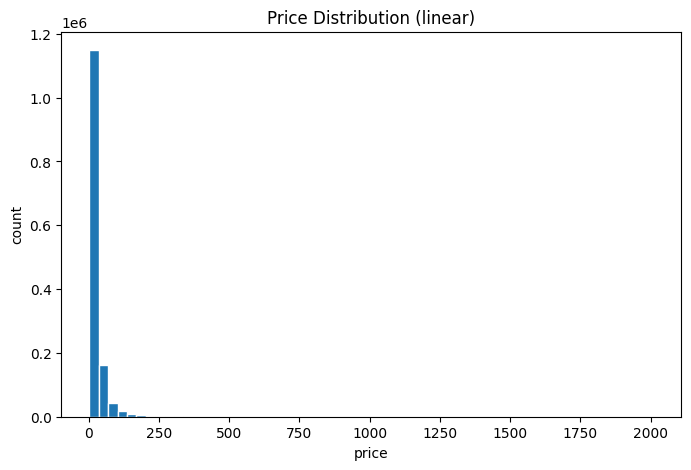

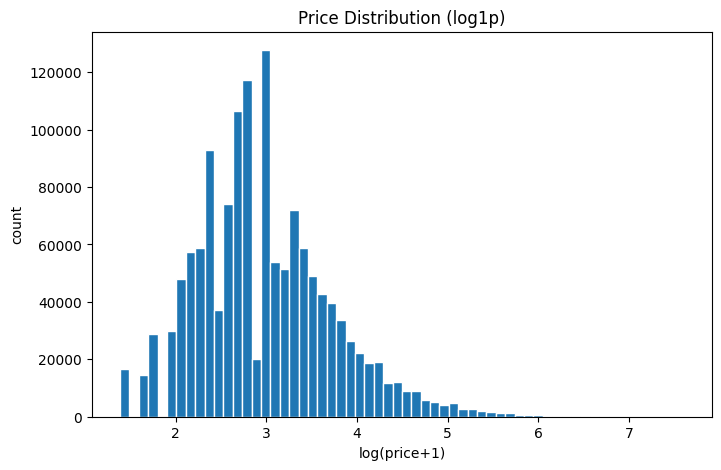

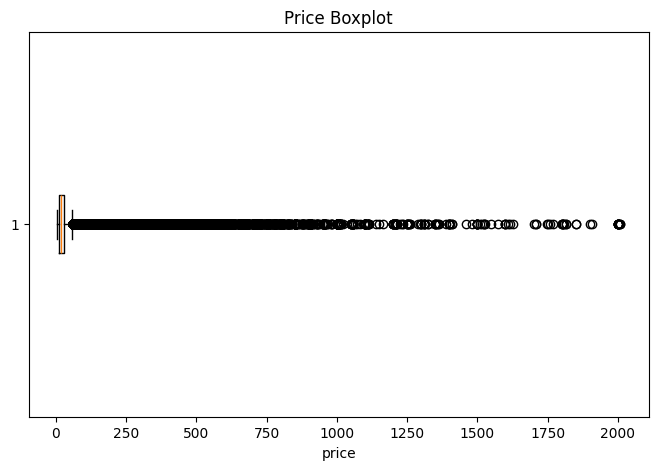

In [151]:

import numpy as np
import matplotlib.pyplot as plt

# optional: larger plots
plt.rcParams["figure.figsize"] = (8,5)
# basic stats
print(df['price'].describe())

# histogram (linear)
df['price'].plot(kind='hist', bins=60, edgecolor='white')
plt.title('Price Distribution (linear)')
plt.xlabel('price'); plt.ylabel('count'); plt.show()

# add log1p price for modeling
df = df[df['price'] > 0].copy()  # ensure positive
df['log_price'] = np.log1p(df['price'])

# histogram (log)
df['log_price'].plot(kind='hist', bins=60, edgecolor='white')
plt.title('Price Distribution (log1p)')
plt.xlabel('log(price+1)'); plt.ylabel('count'); plt.show()

# boxplot (linear)
plt.boxplot(df['price'], vert=False, showfliers=True)
plt.title('Price Boxplot'); plt.xlabel('price'); plt.show()

  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)

[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


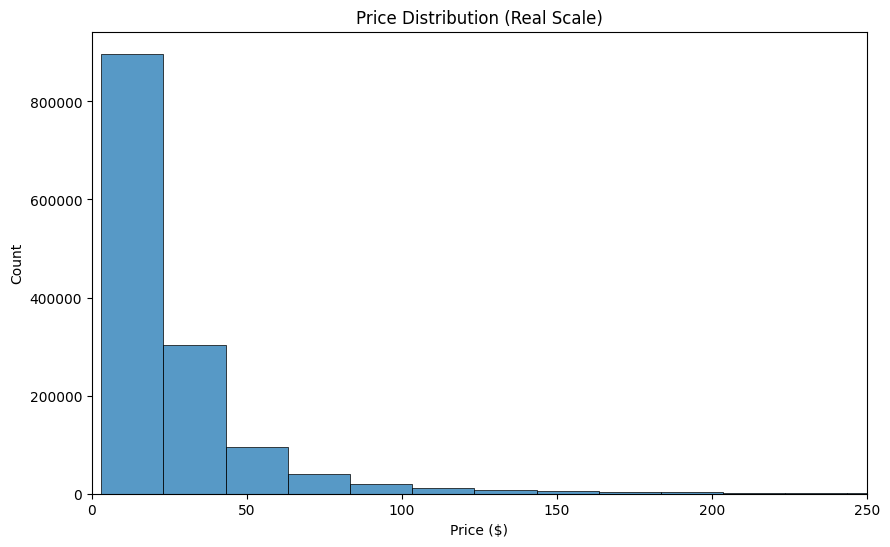

In [105]:
%pip install seaborn
import seaborn as sns

# Plot distribution in real price scale
plt.figure(figsize=(10,6))
sns.histplot(df["price"], bins=100, kde=False)

plt.title("Price Distribution (Real Scale)")
plt.xlabel("Price ($)")
plt.ylabel("Count")
plt.xlim(0, 250)  # cap x-axis to make long tail visible, otherwise high prices stretch it out
plt.show()

In [109]:
# 	1.	Check categories → which categories dominate the dataset? (men/women’s fashion vs electronics, etc.).
# 2.	Look at brand_name coverage → how many known vs unknown?
# 3.	Explore item_condition_id → does condition correlate strongly with price?
# 4.	Check item_description lengths → long descriptions vs short ones (text length as a feature).

temp = pd.DataFrame()
temp[["cat1", "cat2", "cat3"]] = df['category'].str.split(' / ', expand=True, n=2)
temp.head()


,cat1,cat2,cat3
1,electronics,computers & tablets,components & parts
2,women,tops & blouses,blouse
3,home,home décor,home décor accents
4,women,jewelry,necklaces
5,women,other,other


In [158]:
%pip install sklearn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SK

In [170]:
%pip install scikit-learn

  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/8d/a1/d3a7628630a711e2ac0d1a482910da174b629f44e7dd8cfcd6924a4ef81a/scikit_learn-1.7.1-cp311-cp311-macosx_12_0_arm64.whl.metadata
  Obtaining dependency information for scipy>=1.8.0 from https://files.pythonhosted.org/packages/d9/eb/e931853058607bdfbc11b86df19ae7a08686121c203483f62f1ecae5989c/scipy-1.16.1-cp311-cp311-macosx_14_0_arm64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.1 MB/s eta 0:00:00
  Obtaining dependency information for joblib>=1.2.0 from https://files.pythonhosted.org/packages/1e/e8/685f47e0d754320684db4425a0967f7d3fa70126bffd76110b7009a0090f/joblib-1.5.2-py3-none-any.whl.metadata
  Obtaining dependency information for threadpoolctl>=3.1.0 from https://files.pythonhosted.org/packages/32/d5/f9a850d79b0851d1d4ef6456097579a9005b31fea68726a4ae5f2d82ddd9/threadpoolctl-3.6.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 

In [181]:
import sklearn
from sklearn.model_selection import train_test_split

colum_to_move = df.pop("price")
df.insert(5, "price", colum_to_move)

cat1 = df["category_name"].str.split("/", expand=True)[0]

train_df, temp = train_test_split(df,stratify= cat1,test_size=0.2, random_state=42)


val_df, test_df = train_test_split(temp, stratify= cat1,test_size=0.5, random_state=42)
#
train_df.head()
val_df.head()
test_df.head()
# train_df, val_df = train_test_split()

ValueError: Found input variables with inconsistent numbers of samples: [278907, 1394534]

In [152]:
# temp["cat1"].value_counts(normalize=False, sort=True, ascending=False, bins=None, dropna=True)
# temp["cat2"].value_counts(normalize=False, sort=True, ascending=False, bins=None, dropna=True)
# temp["cat3"].value_counts(normalize=False, sort=True, ascending=False, bins=None, dropna=True)
# df["category_name"].value_counts(normalize=False, sort=True, ascending=False, bins=None, dropna=True)
brand_counts = df["brand_name"].value_counts(normalize=False, sort=True, ascending=False, bins=None, dropna=True)

print(type(brand_counts))
min_count = 50
rare_low, rare_mid = [], []
for item,count in brand_counts.items():
    if count < 10:
        rare_low.append(item)
    elif count < min_count:
        rare_mid.append(item)



df.head()




<class 'pandas.core.series.Series'>


,name,item_condition_id,category_name,brand_name,price,item_description,log_price
1,razer blackwidow chroma keyboard,3,electronics/computers & tablets/components & p...,razer,52.0,this keyboard is in great condition and works ...,3.970292
2,ava-viv blouse,1,women/tops & blouses/blouse,target,10.0,adorable top with a hint of lace and a key hol...,2.397895
3,leather horse statues,1,home/home décor/home décor accents,unknown,35.0,new with tags. leather horses. retail for [rm]...,3.583519
4,24k gold plated rose,1,women/jewelry/necklaces,unknown,44.0,complete with certificate of authenticity,3.806662
5,bundled items requested for ruie,3,women/other/other,unknown,59.0,"banana republic bottoms, candies skirt with ma...",4.094345
